# Treniranje jezičkog modela

In [1]:
import flair.datasets
from flair.data import Sentence, Dictionary
from flair.embeddings import WordEmbeddings, FlairEmbeddings, StackedEmbeddings
from flair.models import SequenceTagger, LanguageModel
from flair.trainers import ModelTrainer, LanguageModelTrainer, TextCorpus
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import collections
import glob
import pickle

### Generisanje rečnika

In [2]:
char_dictionary: Dictionary = Dictionary()
counter = collections.Counter()

In [3]:
files = glob.glob('corpus/**/*', recursive=True)
files.remove('corpus\\train')
print(files)

['corpus\\test.txt', 'corpus\\valid.txt', 'corpus\\train\\train_split_1', 'corpus\\train\\train_split_2']


In [4]:
# Number of processed lines
processed = 0

for file in files:

    with open(file, 'r', encoding='utf-8') as f:

        tokens = 0

        for line in f:
            processed += 1
            chars = list(line)
            tokens += len(chars)

            # Add chars to the dictionary
            counter.update(chars)


In [5]:
counter.keys()

dict_keys(['1', '9', '8', '4', 'K', 'a', 'o', ' ', 'i', 'b', 'č', 'n', ',', 'l', 'c', 'e', 'E', 'm', 'u', 'G', 'd', 'š', 't', 'j', 'N', 'r', 'g', 'p', '-', 's', 'k', '.', 'T', 'z', 'S', 'ž', 'h', 'đ', 'v', '(', ')', 'ć', 'P', 'V', 'B', 'D', 'O', ':', '–', 'f', '\n', '2', '0', 'I', 'M', 'A', 'U', 'L', 'Č', '’', '„', '!', '“', 'R', ';', 'J', 'Ž', 'Š', '3', 'Z', 'Ć', '5', '6', '7', '?', '/', 'H', '*', 'w', 'y', 'X', 'Y', 'ñ', '\xad', 'F', '=', 'â', 'C', '—', '[', ']', '_', "'", '^', '|', '&', '>', '<', '{', '}', '#', '+', '%', '”', '\\', '`', '~', 'Đ', '"'])

In [6]:
# Listing elements from most common to least common and summarizing their count
total_count = 0
for letter, count in counter.most_common():
    total_count += count

In [7]:
print("Total number of characters:",total_count)
print("Total number of processed lines:", processed)

Total number of characters: 67079
Total number of processed lines: 93


In [8]:
latin = set("abcčćddžđefghijklljmnnjoprsštuvzžABCČĆDDŽĐEFGHIJKLLJMNNJOPRSŠTUVZŽ")
numbers = set("0123456789")
punct = set(".?!,:;\"\'\/()[]{}_+-*^%#<>|&`~")

In [9]:
latin.issubset(set(counter.keys()))

True

In [10]:
numbers.issubset(set(counter.keys()))

True

In [11]:
punct.issubset(set(counter.keys()))

True

In [12]:
summ = 0
idx = 0
for letter, count in counter.most_common():
    summ += count
    percentile = (summ / total_count)

    char_dictionary.add_item(letter)
    idx += 1
    print('%d\t%s\t%7d\t%7d\t%f' % (idx, letter, count, summ, percentile))

1	 	  11740	  11740	0.175018
2	a	   5880	  17620	0.262675
3	o	   5229	  22849	0.340628
4	e	   4862	  27711	0.413110
5	i	   4649	  32360	0.482416
6	n	   3353	  35713	0.532402
7	r	   2515	  38228	0.569895
8	t	   2454	  40682	0.606479
9	s	   2400	  43082	0.642258
10	j	   2223	  45305	0.675398
11	u	   2144	  47449	0.707360
12	d	   1967	  49416	0.736684
13	l	   1810	  51226	0.763667
14	m	   1774	  53000	0.790113
15	k	   1762	  54762	0.816381
16	v	   1736	  56498	0.842261
17	p	   1390	  57888	0.862982
18	g	    940	  58828	0.876996
19	,	    831	  59659	0.889384
20	b	    793	  60452	0.901206
21	z	    786	  61238	0.912924
22	.	    603	  61841	0.921913
23	č	    509	  62350	0.929501
24	š	    480	  62830	0.936657
25	c	    364	  63194	0.942083
26	ž	    302	  63496	0.946585
27	h	    272	  63768	0.950640
28	ć	    244	  64012	0.954278
29	-	    133	  64145	0.956261
30	1	    122	  64267	0.958079
31	S	    122	  64389	0.959898
32	f	    118	  64507	0.961657
33	A	    108	  64615	0.963267
34	đ	    101	  6471

In [13]:
with open('resources/char_mappings/latin_dict', 'wb') as f:
    mappings = {
        'idx2item': char_dictionary.idx2item,
        'item2idx': char_dictionary.item2idx
    }
    pickle.dump(mappings, f)

### Traniranje embedding-a

In [15]:
is_forward_lm = True
dictionary: Dictionary = Dictionary.load_from_file('resources/char_mappings/latin_dict')

# get your corpus, process forward and at the character level
corpus = TextCorpus('corpus',
                    dictionary,
                    is_forward_lm,
                    character_level=True)

# instantiate your language model, set hidden size and number of layers
# U pozadini LanguageModel-a je rekurzivna neuronska mreza iz PyTorch bibloteke, konkretno LSTM ili GRU
language_model = LanguageModel(dictionary,
                               is_forward_lm,
                               hidden_size=128,
                               nlayers=1)
trainer = LanguageModelTrainer(language_model, corpus)

trainer.train('resources/taggers/language_model',
              sequence_length=40,
              mini_batch_size=20,
              max_epochs=20)

2022-08-29 19:10:58,558 read text file with 8 lines
2022-08-29 19:10:58,603 read text file with 8 lines
2022-08-29 19:11:05,207 Sequence length is 40
2022-08-29 19:11:05,210 Split 1	 - (19:11:05)
2022-08-29 19:11:08,059 best split so far
2022-08-29 19:11:08,061 best loss so far 3.44394191
2022-08-29 19:27:22,617 ("\nekokoulomagueviiuauaonejetavetezliosvorugoodiajuo{iiaeikle,nikiinamvakuimojauateeodesaira?ese!čeroumonta!spanaapodairriinikeaiavaktakiiiijaireaiveaieozađee sjiloiniouaakeaaneliekiomivoOojeiula^elisuiazesapuucamoarikoikenejojanitkuieaebainaebakiTaoyairgcagilaanaĐod#ua ijeidaaemiukiobeAlegioči:aevosHmijimaćeitavevlesavakiote,ajaeloi,ovžnaanjateliriron-einauoueCeivauRpovaijegida/ini1aorIomoiuudkiizupJerokiojejaikina0a piapoj:im,knejraukičikjeu)uuaniuučaorlanaoraća_ahtavblolyuâoemikuroujorpiemidgesepaoa4adatataiuagacesimara.oDpcjitodaD dloldeleliomaneadajoupaipier\namošisitehji1uineaiši,nošeori.r&er,aauiunjelšaaraviridaČiimapejopaočdivadokaagikeelrenaučosaoedionaajbi'nakFijoken

In [27]:
sentence = Sentence('Ja volim Beograd.')

# init embeddings from your trained LM
char_lm_embeddings = FlairEmbeddings('resources/taggers/language_model/best-lm.pt')

# embed sentence
char_lm_embeddings.embed(sentence)

for token in sentence:
    print(token)
    print(token.embedding)

Token[0]: "Ja"
tensor([ 5.3048e-02,  2.2628e-02, -2.4065e-01, -3.2827e-02,  5.6061e-03,
        -4.2467e-01, -3.1951e-02, -1.5405e-01,  2.2534e-02, -5.8237e-03,
         8.2214e-03,  3.7881e-02, -9.6464e-02,  1.3770e-02,  8.9410e-03,
         3.9715e-03, -1.2725e-04, -1.3034e-01,  2.6640e-02,  1.5326e-02,
         8.0925e-04,  6.1014e-02,  5.7925e-02, -5.0390e-03,  8.3427e-05,
        -3.6970e-02,  7.7306e-03,  4.0450e-02,  9.5872e-02,  1.9486e-01,
        -5.8637e-02,  3.7620e-03,  3.1913e-02, -6.6242e-03, -5.4703e-02,
        -8.5106e-03,  1.9416e-02, -8.9536e-02,  1.4042e-02,  1.5402e-01,
        -6.4205e-01,  2.0794e-02, -2.2875e-03, -1.3731e-02, -4.9120e-03,
        -8.8175e-04,  2.8304e-03, -8.8917e-03,  2.0393e-01, -1.1141e-01,
        -2.3095e-03,  1.7074e-01,  1.0975e-02, -1.1415e-02, -6.0489e-01,
        -1.2989e-02, -2.6028e-02,  3.4762e-02, -2.7771e-05,  2.2747e-01,
         6.3971e-03,  3.4762e-03,  2.5448e-04, -1.2413e-01, -8.9948e-02,
        -3.1990e-02,  1.3503e-03,  1

In [28]:
corpus_1 = flair.datasets.UD_SERBIAN().downsample(0.1)

2022-08-29 20:23:15,574 Reading data from C:\Users\Goran\.flair\datasets\ud_serbian
2022-08-29 20:23:15,577 Train: C:\Users\Goran\.flair\datasets\ud_serbian\sr_set-ud-train.conllu
2022-08-29 20:23:15,578 Dev: C:\Users\Goran\.flair\datasets\ud_serbian\sr_set-ud-dev.conllu
2022-08-29 20:23:15,581 Test: C:\Users\Goran\.flair\datasets\ud_serbian\sr_set-ud-test.conllu


In [29]:
label_type = 'upos'
label_dict  = corpus_1.make_label_dictionary(label_type = label_type)

2022-08-29 20:23:32,412 Computing label dictionary. Progress:


333it [00:00, 5842.02it/s]

2022-08-29 20:23:32,477 Dictionary created for label 'upos' with 17 values: NOUN (seen 1830 times), PUNCT (seen 974 times), ADJ (seen 888 times), ADP (seen 688 times), VERB (seen 616 times), PROPN (seen 530 times), AUX (seen 454 times), DET (seen 287 times), CCONJ (seen 275 times), ADV (seen 263 times), SCONJ (seen 261 times), PRON (seen 182 times), NUM (seen 68 times), PART (seen 45 times), X (seen 30 times), SYM (seen 1 times)


In [30]:
embedding_types = [
    WordEmbeddings('glove'),
    FlairEmbeddings('resources/taggers/language_model/best-lm.pt')
]

embeddings = StackedEmbeddings(embeddings=embedding_types)

In [31]:
tagger = SequenceTagger(hidden_size=256,
                        embeddings=embeddings,
                        tag_dictionary=label_dict,
                        tag_type=label_type,
                        use_crf=True)

trainer = ModelTrainer(tagger, corpus_1)

2022-08-29 20:23:45,846 SequenceTagger predicts: Dictionary with 17 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, CCONJ, ADV, SCONJ, PRON, NUM, PART, X, SYM


In [32]:
trainer.train('resources/taggers/language_model_testing',
              learning_rate=0.1,
              mini_batch_size=500,
              max_epochs=2)

2022-08-29 20:24:01,929 ----------------------------------------------------------------------------------------------------
2022-08-29 20:24:01,931 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=228, out_features=228, bias=True)
  (rnn): LSTM(228, 256, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=512, out_features=19, bias=True)
  (loss_function): ViterbiLoss()
  (crf): CRF()
)"
2022-08-29 20:24:01,932 ------------------------------------------------------------------

C:\Users\Goran\anaconda3\envs\ml\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-08-29 20:24:15,336 epoch 1 - iter 1/1 - loss 3.47267844 - samples/sec: 37.39 - lr: 0.100000
2022-08-29 20:24:15,338 ----------------------------------------------------------------------------------------------------
2022-08-29 20:24:15,340 EPOCH 1 done: loss 3.4727 - lr 0.100000


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

2022-08-29 20:24:16,394 Evaluating as a multi-label problem: False
2022-08-29 20:24:16,438 DEV : loss 3.332317352294922 - f1-score (micro avg)  0.0711
2022-08-29 20:24:16,453 BAD EPOCHS (no improvement): 0
2022-08-29 20:24:16,456 saving best model


2022-08-29 20:24:18,449 ----------------------------------------------------------------------------------------------------
2022-08-29 20:24:29,835 epoch 2 - iter 1/1 - loss 3.27634737 - samples/sec: 43.94 - lr: 0.100000
2022-08-29 20:24:29,837 ----------------------------------------------------------------------------------------------------
2022-08-29 20:24:29,839 EPOCH 2 done: loss 3.2763 - lr 0.100000


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

2022-08-29 20:24:30,474 Evaluating as a multi-label problem: False
2022-08-29 20:24:30,501 DEV : loss 3.1565616130828857 - f1-score (micro avg)  0.2256
2022-08-29 20:24:30,514 BAD EPOCHS (no improvement): 0
2022-08-29 20:24:30,516 saving best model


2022-08-29 20:24:34,384 ----------------------------------------------------------------------------------------------------
2022-08-29 20:24:34,388 loading file resources\taggers\language_model_testing\best-model.pt
2022-08-29 20:24:35,042 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, CCONJ, ADV, SCONJ, PRON, NUM, PART, X, SYM, <START>, <STOP>


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

2022-08-29 20:24:36,277 Evaluating as a multi-label problem: False
2022-08-29 20:24:36,304 0.2593	0.2593	0.2593	0.2593
2022-08-29 20:24:36,306 
Results:
- F-score (micro) 0.2593
- F-score (macro) 0.0271
- Accuracy 0.2593

By class:
              precision    recall  f1-score   support

        NOUN     0.2774    0.9862    0.4330       290
         ADJ     0.0000    0.0000    0.0000       148
       PUNCT     0.0000    0.0000    0.0000       143
         ADP     0.0000    0.0000    0.0000        93
        VERB     0.0000    0.0000    0.0000        93
       PROPN     0.0000    0.0000    0.0000        77
         SYM     0.0000    0.0000    0.0000         0
         AUX     0.0000    0.0000    0.0000        61
       SCONJ     0.0000    0.0000    0.0000        42
       CCONJ     0.0000    0.0000    0.0000        41
         DET     0.0000    0.0000    0.0000        36
         ADV     0.0000    0.0000    0.0000        32
        PRON     0.0000    0.0000    0.0000        30
         NU

{'test_score': 0.25929283771532186,
 'dev_score_history': [0.07107438016528926, 0.2256198347107438],
 'train_loss_history': [3.472678444602273, 3.2763473708908277],
 'dev_loss_history': [3.332317352294922, 3.1565616130828857]}

In [33]:
# load the model you trained
model = SequenceTagger.load('resources/taggers/language_model_testing/final-model.pt')

2022-08-29 20:25:38,090 loading file resources/taggers/language_model_testing/final-model.pt
2022-08-29 20:25:38,805 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, CCONJ, ADV, SCONJ, PRON, NUM, PART, X, SYM, <START>, <STOP>


In [34]:


# create example sentence
# TODO: Matrica konfuzije za predikciju,
actualSentenceExample = corpus_1.dev[17]
predictedSentenceExample = Sentence(actualSentenceExample.to_plain_string())
model.predict(predictedSentenceExample)
print("\n\n")
# predict tags and print

for i,token in enumerate(predictedSentenceExample):
    predictedLabels = token.get_labels('upos')
    actualLabels = actualSentenceExample[i].get_labels('upos')

    for j, label in enumerate(predictedLabels):
        token = label.data_point.form
        predictedValue = label.value
        actualValue = actualLabels[j].value

        print(token, "- predicted:" ,predictedValue, ", actual:", actualValue)




" - predicted: NOUN , actual: PUNCT
Razmatrali - predicted: NOUN , actual: VERB
smo - predicted: NOUN , actual: AUX
situaciju - predicted: NOUN , actual: NOUN
i - predicted: NOUN , actual: CCONJ
postupanje - predicted: NOUN , actual: NOUN
prema - predicted: NOUN , actual: ADP
manjinama - predicted: NOUN , actual: NOUN
u - predicted: NOUN , actual: ADP
Albaniji - predicted: NOUN , actual: PROPN
i - predicted: NOUN , actual: CCONJ
napravljen - predicted: NOUN , actual: ADJ
je - predicted: NOUN , actual: AUX
' - predicted: NOUN , actual: PUNCT
ustavni - predicted: NOUN , actual: ADJ
' - predicted: NOUN , actual: PUNCT
dokument - predicted: NOUN , actual: NOUN
u - predicted: NOUN , actual: ADP
okviru - predicted: NOUN , actual: NOUN
ustava - predicted: NOUN , actual: NOUN
, - predicted: NOUN , actual: PUNCT
sa - predicted: NOUN , actual: ADP
pravima - predicted: NOUN , actual: NOUN
manjina - predicted: NOUN , actual: NOUN
u - predicted: NOUN , actual: ADP
Albaniji - predicted: NOUN , ac

In [235]:
actual= np.array([])
predicted = np.array([])

for actualSentence in corpus_1.dev:
    predictedSentence = Sentence(actualSentence.to_plain_string())
    model.predict(predictedSentence)


    numTokens = min(len(predictedSentence.tokens),len(actualSentence.tokens))
    i=0
    punctCount = 0

    while i+punctCount<numTokens:
        actualLabels = actualSentence[i].get_labels('upos')

        if predictedSentence[i+punctCount].labels[0].data_point.form == ".":
            punctCount+=1

        if i+punctCount >= numTokens:
            break
        predictedLabels = predictedSentence[i+punctCount].get_labels('upos')

        numLabels = min(len(actualLabels),len(predictedLabels))
        j=0
        while j<numLabels:
            predicted = np.append(predicted, predictedLabels[j].value)
            actual = np.append(actual, actualLabels[j].value)
            j+=1
        i+=1


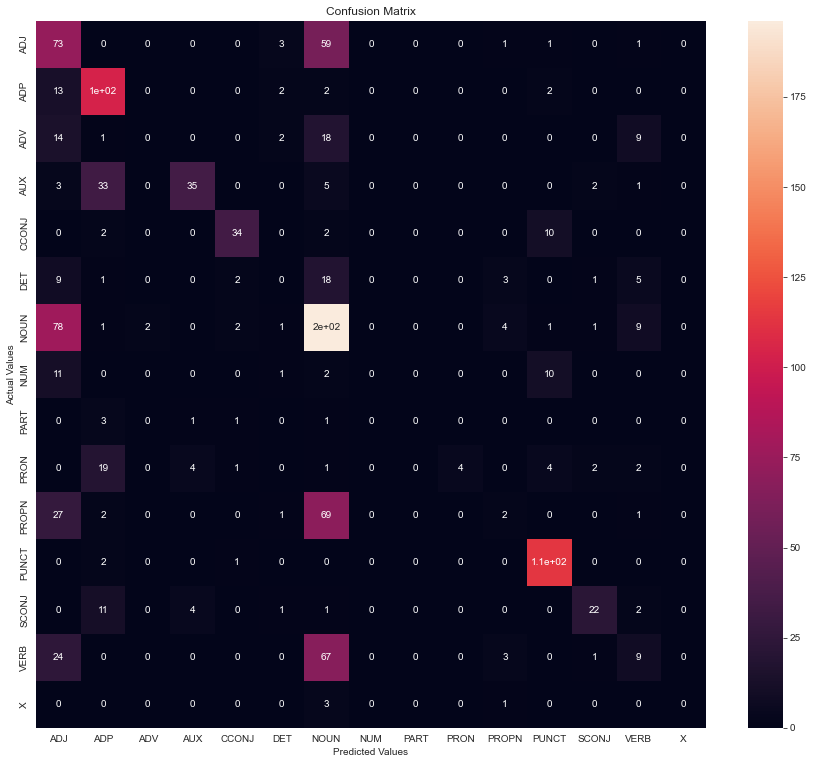

In [236]:
classes = np.union1d(np.unique(actual), np.unique(predicted))
cm = metrics.confusion_matrix(actual, predicted)
cm_df = pd.DataFrame(cm,
                     index = classes,
                     columns = classes)
#Plotting the confusion matrix
plt.figure(figsize=(15,13))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [237]:
sentence = Sentence('Srbija je tokom bombardovanja devedesetih izgubila mnoge kulturne znamenitosti.')

# predict tags and print
model.predict(sentence)

print(sentence.to_tagged_string())

Sentence: "Srbija je tokom bombardovanja devedesetih izgubila mnoge kulturne znamenitosti ." → ["Srbija"/VERB, "je"/ADP, "tokom"/NOUN, "bombardovanja"/ADJ, "devedesetih"/NOUN, "izgubila"/ADJ, "mnoge"/NOUN, "kulturne"/ADJ, "znamenitosti"/NOUN, "."/PUNCT]
